# PapyrusNU Hieroglyph Detection - Data Preparation

This notebook handles data preparation for training a Detectron2 model to identify hieroglyphs in papyrus images.

## Objectives:
1. Load and validate the dataset
2. Analyze dataset statistics
3. Split data into train/val/test sets
4. Prepare data for Detectron2 training
5. Visualize sample annotations

## Setup

In [1]:
# install dependencies
!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.1/888.1 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 141.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.2/287.2 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

'2.8.0+cu128'

In [1]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

fatal: destination path 'detectron2_repo' already exists and is not an empty directory.
Obtaining file:///content/detectron2_repo
  Preparing metadata (setup.py) ... done
  Attempting uninstall: detectron2
    Found existing installation: detectron2 0.6
    Uninstalling detectron2-0.6:
      Successfully uninstalled detectron2-0.6
  Running setup.py develop for detectron2


In [3]:
import subprocess
import sys
import torch


# Check CUDA version to pick the correct Detectron2 wheel
cuda_version = torch.version.cuda
print(f"Detected CUDA version: {cuda_version}")

# Install other required packages that are not included with the detectron2 installation command
print("\nInstalling other required packages...")
other_packages = [
    'opencv-python-headless',
    'matplotlib>=3.3.0',
    'seaborn>=0.11.0',
    'plotly>=5.0.0',
    'pandas>=1.3.0',
    'scikit-learn>=1.0.0',
    'kaleido>=0.2.1',
    'pycocotools',
    'pillow>=8.0.0',
    'numpy',
    'tqdm',
    'ipywidgets'
]

try:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q'] + other_packages)
    print("✅ All other packages installed successfully!")
except subprocess.CalledProcessError as e:
    print(f"❌ Failed to install other packages: {e}")
except Exception as e:
    print(f"❌ Installation of other packages failed: {e}")

Detected CUDA version: 12.8

Installing other required packages...
✅ All other packages installed successfully!


In [4]:
# Import libraries
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import pandas as pd
from pathlib import Path
from google.colab import drive, files
import zipfile
import shutil

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set up paths
PROJECT_ROOT = '/content/drive/My Drive/PapyrusNU_Detectron'


DATA_DIR = f'{PROJECT_ROOT}/data'
SCRIPTS_DIR = f'{PROJECT_ROOT}/scripts'
MODELS_DIR = f'{PROJECT_ROOT}/models'
NOTEBOOKS_DIR = f'{PROJECT_ROOT}/notebooks'

# Add scripts to path
sys.path.append(SCRIPTS_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Loading and Validation

In [5]:
import sys
import os

print("Current system path:")
for path in sys.path:
    print(path)

print("\nContents of scripts directory:")
scripts_dir = '/content/drive/My Drive/PapyrusNU_Detectron/scripts'
if os.path.exists(scripts_dir):
    for item in os.listdir(scripts_dir):
        print(item)
else:
    print(f"Directory not found: {scripts_dir}")

Current system path:
/content
/env/python
/usr/lib/python311.zip
/usr/lib/python3.11
/usr/lib/python3.11/lib-dynload

/usr/local/lib/python3.11/dist-packages
/content/detectron2_repo
/usr/lib/python3/dist-packages
/usr/local/lib/python3.11/dist-packages/IPython/extensions
/root/.ipython
/content/drive/My Drive/PapyrusNU_Detectron/scripts

Contents of scripts directory:
visualization.py
evaluation.py
dataset_utils.py
__pycache__


In [6]:
# Import our custom utilities
from dataset_utils import HieroglyphDatasetUtils
from visualization import HieroglyphVisualizer

# Initialize dataset utilities
annotation_file = f"{DATA_DIR}/annotations/annotations.json"
dataset_utils = HieroglyphDatasetUtils(annotation_file)

print("Dataset loaded successfully!")
print(f"Number of images: {len(dataset_utils.images)}")
print(f"Number of annotations: {len(dataset_utils.annotations)}")
print(f"Number of categories: {len(dataset_utils.categories)}")

Dataset loaded successfully!
Number of images: 1
Number of annotations: 2430
Number of categories: 628


In [7]:
# Validate annotations
print("Validating annotations...")
issues = dataset_utils.validate_annotations()

print("\nValidation Results:")
for issue_type, issue_list in issues.items():
    if issue_list:
        print(f"⚠️  {issue_type}: {len(issue_list)} issues")
        if len(issue_list) <= 5:
            print(f"   Sample IDs: {issue_list}")
        else:
            print(f"   Sample IDs: {issue_list[:5]} ... (and {len(issue_list)-5} more)")
    else:
        print(f"✅ {issue_type}: No issues")

Validating annotations...

Validation Results:
✅ missing_segmentation: No issues
✅ invalid_bbox: No issues
✅ zero_area: No issues
✅ missing_unicode: No issues
✅ invalid_category: No issues


## Dataset Statistics and Analysis

In [8]:
# Get comprehensive dataset statistics
print("Computing dataset statistics...")
stats = dataset_utils.get_dataset_stats()

print("\n📊 Dataset Overview:")
print(f"Images: {stats['num_images']:,}")
print(f"Annotations: {stats['num_annotations']:,}")
print(f"Categories: {stats['num_categories']:,}")
print(f"Unique Unicode codes: {stats['unique_unicode_codes']:,}")
print(f"Unique Gardiner codes: {stats['unique_gardiner_codes']:,}")

print("\n📏 Area Statistics:")
area_stats = stats['area_stats']
print(f"Mean area: {area_stats['mean']:.1f} pixels²")
print(f"Median area: {area_stats['median']:.1f} pixels²")
print(f"Min area: {area_stats['min']:.1f} pixels²")
print(f"Max area: {area_stats['max']:.1f} pixels²")
print(f"Std deviation: {area_stats['std']:.1f} pixels²")

print("\n🎯 Most Common Categories:")
for i, (cat_id, count) in enumerate(stats['most_common_categories'][:10], 1):
    cat_name = dataset_utils.categories[cat_id]['name']
    print(f"{i:2d}. {cat_name}: {count} annotations")

print("\n🔍 Least Common Categories:")
for i, (cat_id, count) in enumerate(stats['least_common_categories'][:5], 1):
    cat_name = dataset_utils.categories[cat_id]['name']
    print(f"{i:2d}. {cat_name}: {count} annotations")

Computing dataset statistics...

📊 Dataset Overview:
Images: 1
Annotations: 2,430
Categories: 628
Unique Unicode codes: 178
Unique Gardiner codes: 177

📏 Area Statistics:
Mean area: 2794.4 pixels²
Median area: 2345.5 pixels²
Min area: 323.0 pixels²
Max area: 11975.0 pixels²
Std deviation: 1819.6 pixels²

🎯 Most Common Categories:
 1. N35: 206 annotations
 2. X1: 195 annotations
 3. D21: 168 annotations
 4. G43: 120 annotations
 5. Z1: 117 annotations
 6. Aa1: 90 annotations
 7. M17: 77 annotations
 8. Y1: 77 annotations
 9. A1B: 74 annotations
10. W24: 63 annotations

🔍 Least Common Categories:
 1. W3: 1 annotations
 2. G27: 1 annotations
 3. A32h: 1 annotations
 4. F2B: 1 annotations
 5. A317: 1 annotations


In [9]:
# Analyze class balance
print("Analyzing class balance...")
class_balance = dataset_utils.analyze_class_balance()

print(f"\n⚖️  Class Balance Analysis:")
print(f"Total classes: {class_balance['num_classes']}")
print(f"Frequent classes (>5%): {len(class_balance['frequent_classes'])}")
print(f"Common classes (1-5%): {len(class_balance['common_classes'])}")
print(f"Rare classes (<1%): {len(class_balance['rare_classes'])}")

print("\n🔥 Most Frequent Classes:")
for name, count, percentage in class_balance['frequent_classes'][:5]:
    print(f"  {name}: {count} annotations ({percentage:.1f}%)")

print("\n🔍 Some Rare Classes:")
for name, count, percentage in class_balance['rare_classes'][-5:]:
    print(f"  {name}: {count} annotations ({percentage:.1f}%)")

Analyzing class balance...

⚖️  Class Balance Analysis:
Total classes: 177
Frequent classes (>5%): 3
Common classes (1-5%): 22
Rare classes (<1%): 152

🔥 Most Frequent Classes:
  N35: 206 annotations (8.5%)
  X1: 195 annotations (8.0%)
  D21: 168 annotations (6.9%)

🔍 Some Rare Classes:
  Q1: 16 annotations (0.7%)
  V30: 17 annotations (0.7%)
  V28A: 18 annotations (0.7%)
  D54: 23 annotations (0.9%)
  A2: 24 annotations (1.0%)


In [10]:
# Get Gardiner to Unicode mapping
print("Creating Gardiner to Unicode mapping...")
gardiner_mapping = dataset_utils.get_gardiner_mapping()

print(f"\n📚 Gardiner Code Analysis:")
print(f"Total Gardiner codes: {len(gardiner_mapping)}")

# Show some examples
print("\n📝 Sample Gardiner to Unicode mappings:")
sample_codes = list(gardiner_mapping.items())[:10]
for gardiner_code, info in sample_codes:
    unicode_codes = info['unicode_codes']
    count = info['count']
    unicode_str = ', '.join(unicode_codes) if unicode_codes else 'No Unicode'
    print(f"  {gardiner_code}: {unicode_str} ({count} annotations)")

# Save mapping for later use
mapping_file = f"{DATA_DIR}/annotations/gardiner_unicode_mapping.json"
with open(mapping_file, 'w') as f:
    json.dump(gardiner_mapping, f, indent=2)
print(f"\n💾 Mapping saved to {mapping_file}")

Creating Gardiner to Unicode mapping...

📚 Gardiner Code Analysis:
Total Gardiner codes: 177

📝 Sample Gardiner to Unicode mappings:
  D4: U+13079 (34 annotations)
  N35: U+13216 (206 annotations)
  A1B: <g>A1B</g>, U+13000, U+1308B (74 annotations)
  N31: U+13210 (15 annotations)
  X1: U+13171, U+133CF (195 annotations)
  Z1: U+133E4 (117 annotations)
  G43: U+13171 (120 annotations)
  M17: U+131CB, U+13171 (77 annotations)
  D21: U+130BB, U+1308B (168 annotations)
  Aa1: U+13000, U+1340D, U+1308B (90 annotations)

💾 Mapping saved to /content/drive/My Drive/PapyrusNU_Detectron/data/annotations/gardiner_unicode_mapping.json


## Data Visualization

Creating dataset overview plots...


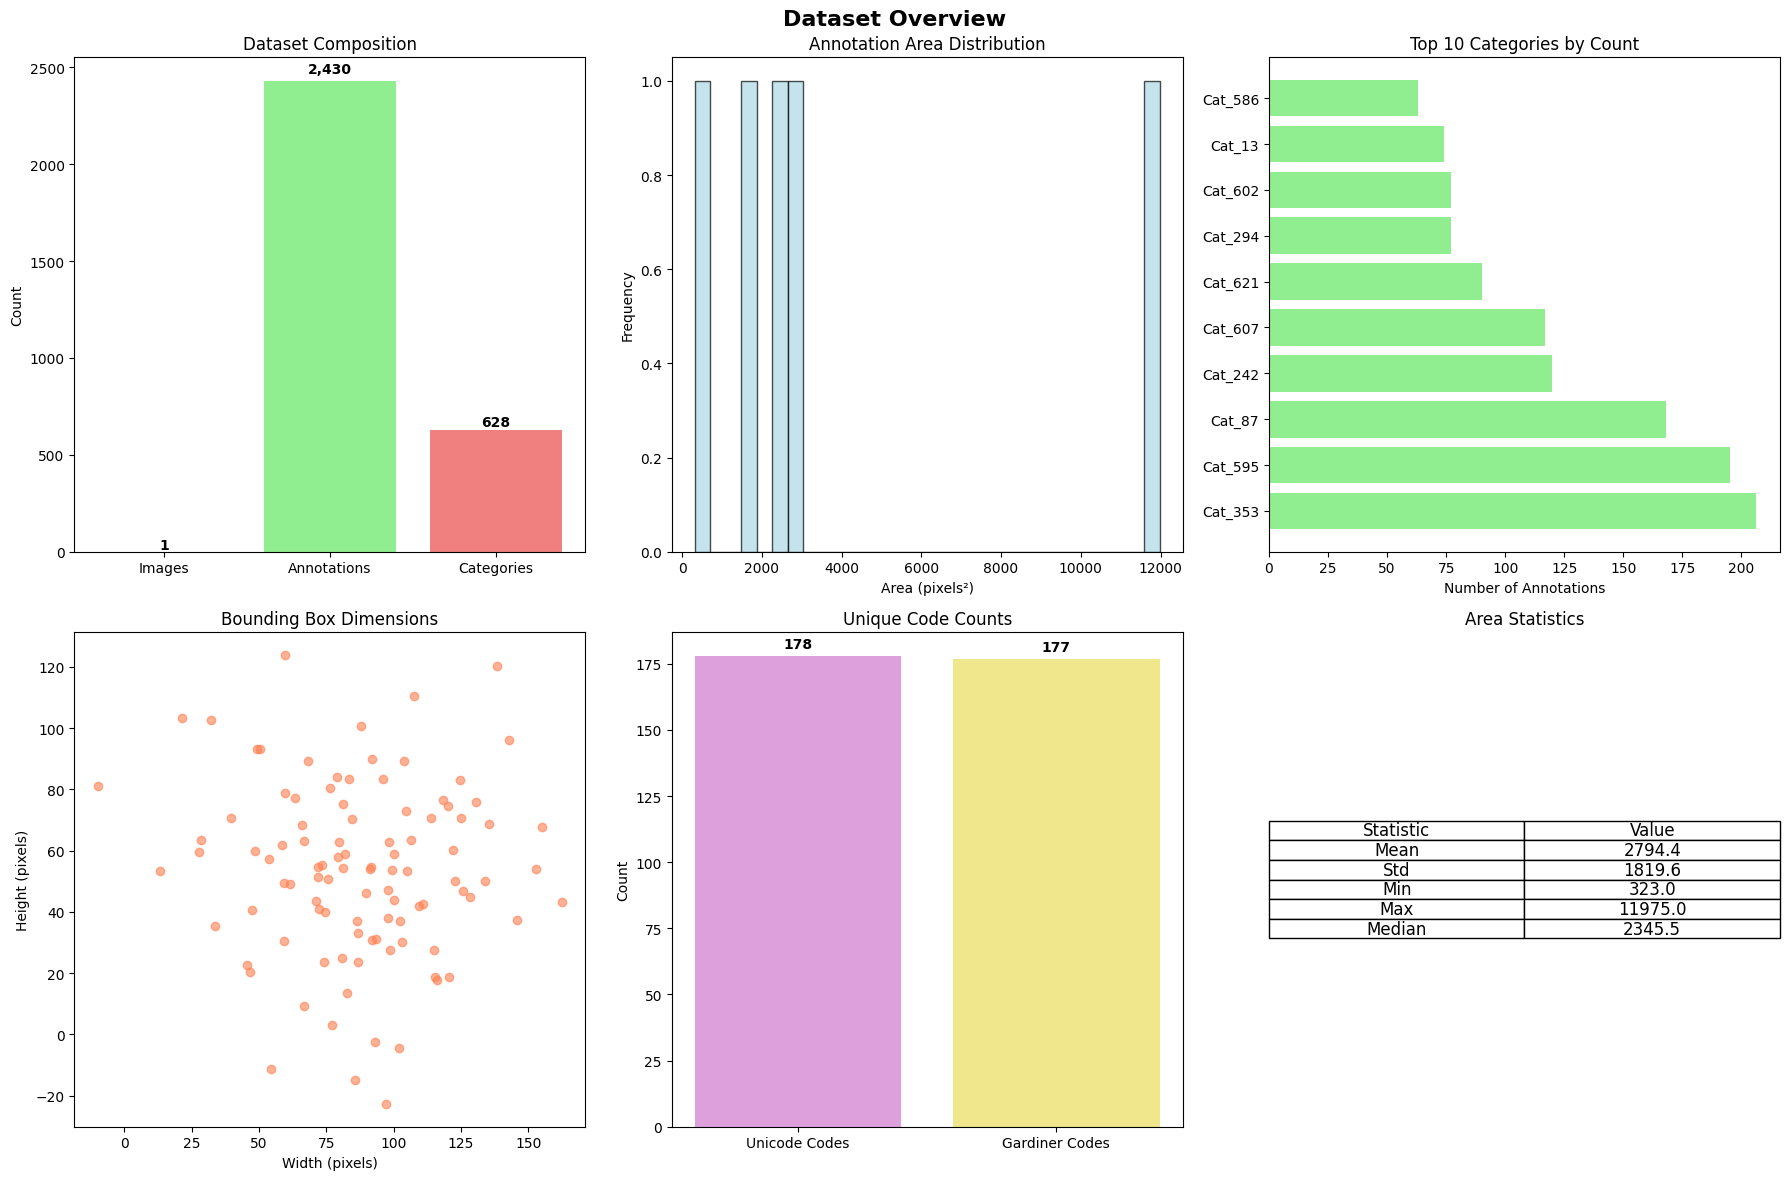


Creating class distribution plots...


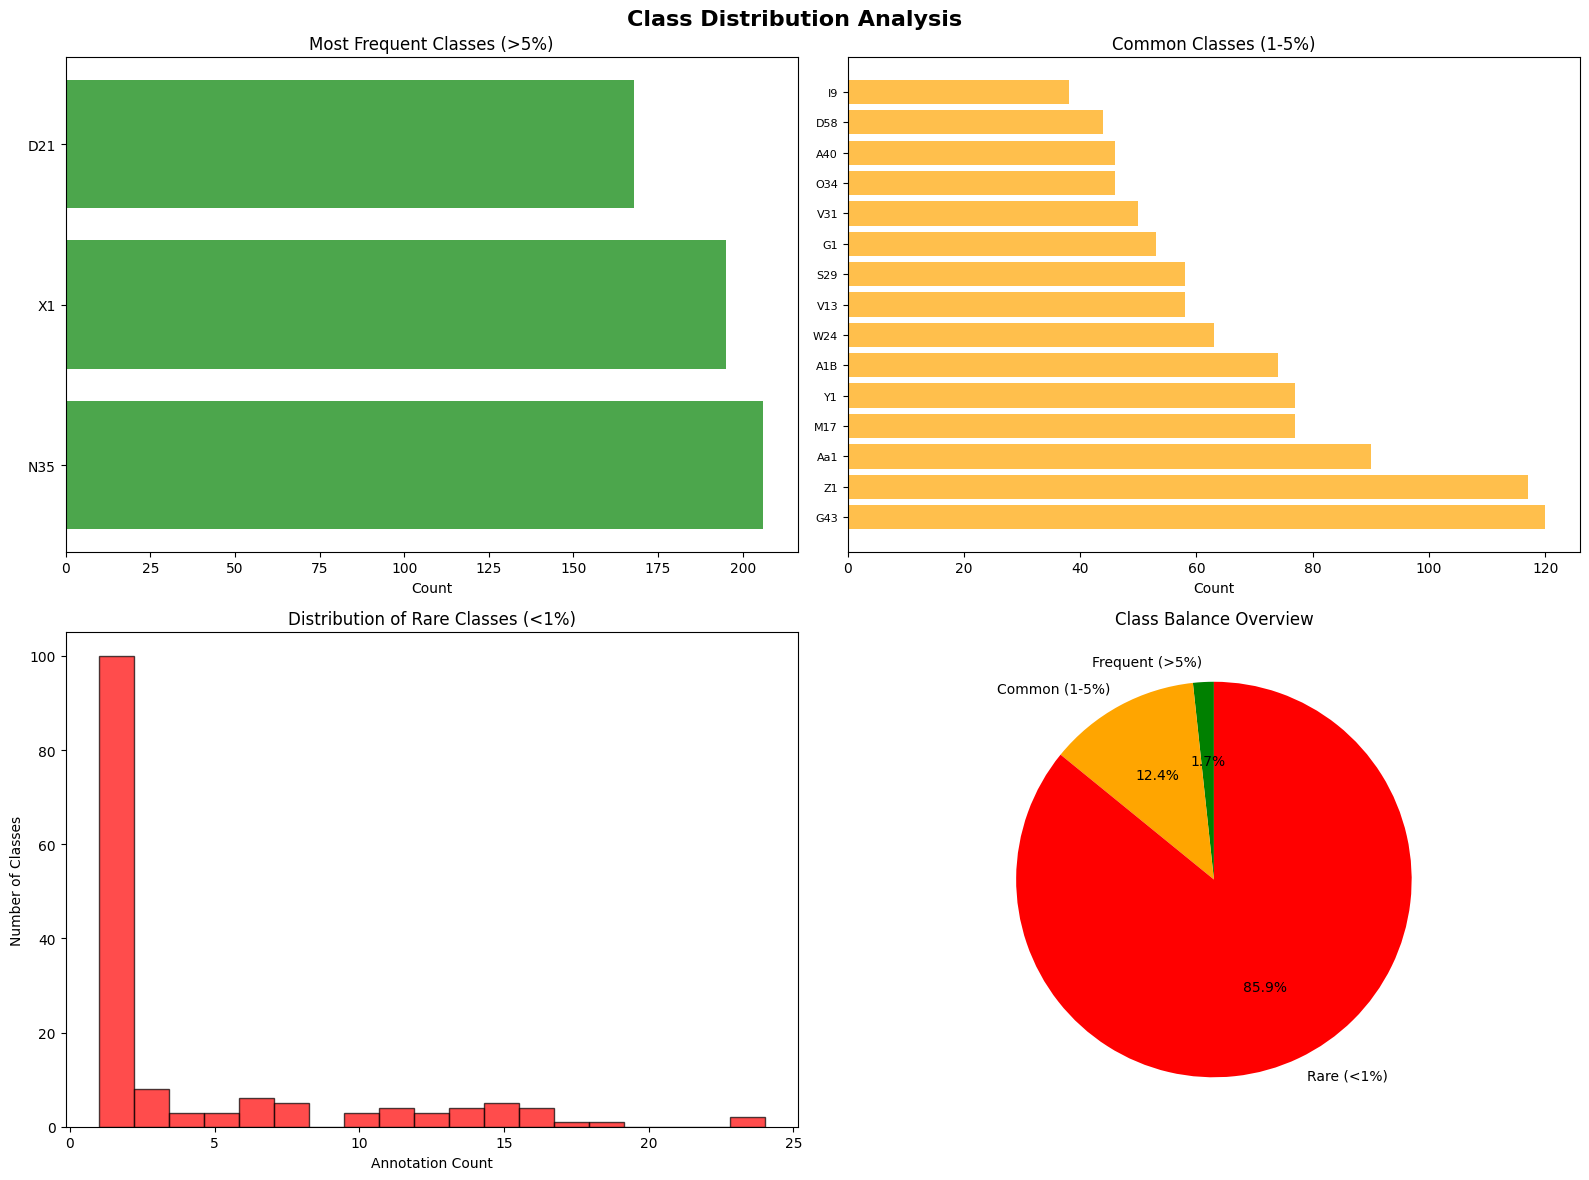

In [11]:
# Initialize visualizer
visualizer = HieroglyphVisualizer(figsize=(15, 10))

# Create the directory for analysis plots if it doesn't exist
analysis_plots_dir = f"{DATA_DIR}/analysis_plots"
os.makedirs(analysis_plots_dir, exist_ok=True)


# Create dataset overview plots
print("Creating dataset overview plots...")
overview_fig = visualizer.plot_dataset_overview(stats,
                                               save_path=f"{analysis_plots_dir}/dataset_overview.png")
plt.show()

# Create class distribution plots
print("\nCreating class distribution plots...")
class_dist_fig = visualizer.plot_class_distribution(class_balance,
                                                   save_path=f"{analysis_plots_dir}/class_distribution.png")
plt.show()

In [12]:
# Visualize annotations on the image
image_path = f"{DATA_DIR}/images/145_upscaled_bright.jpg"

print("Creating annotation visualization...")
# Show a subset of annotations to avoid clutter
annotation_fig = visualizer.visualize_annotations_on_image(
    image_path=image_path,
    annotations=dataset_utils.annotations[:100],  # First 100 annotations
    categories=dataset_utils.categories,
    max_annotations=50,  # Limit displayed annotations
    save_path=f"{DATA_DIR}/analysis_plots/sample_annotations.png"
)
plt.show()

print(f"Note: Showing first 50 of {len(dataset_utils.annotations)} total annotations")

Output hidden; open in https://colab.research.google.com to view.

## Data Splitting

In [13]:
# Split dataset into train/validation/test sets
print("Splitting dataset...")
train_data, val_data, test_data = dataset_utils.split_dataset(
    train_ratio=0.7,
    val_ratio=0.20,
    test_ratio=0.10,
    seed=42
)

print(f"\n📂 Data Split Results:")
print(f"Training set: {len(train_data['annotations']):,} annotations")
print(f"Validation set: {len(val_data['annotations']):,} annotations")
print(f"Test set: {len(test_data['annotations']):,} annotations")
print(f"Total: {len(train_data['annotations']) + len(val_data['annotations']) + len(test_data['annotations']):,} annotations")

# Calculate percentages
total = len(train_data['annotations']) + len(val_data['annotations']) + len(test_data['annotations'])
train_pct = len(train_data['annotations']) / total * 100
val_pct = len(val_data['annotations']) / total * 100
test_pct = len(test_data['annotations']) / total * 100

print(f"\nPercentages:")
print(f"Training: {train_pct:.1f}%")
print(f"Validation: {val_pct:.1f}%")
print(f"Test: {test_pct:.1f}%")

Splitting dataset...

📂 Data Split Results:
Training set: 1,682 annotations
Validation set: 432 annotations
Test set: 316 annotations
Total: 2,430 annotations

Percentages:
Training: 69.2%
Validation: 17.8%
Test: 13.0%


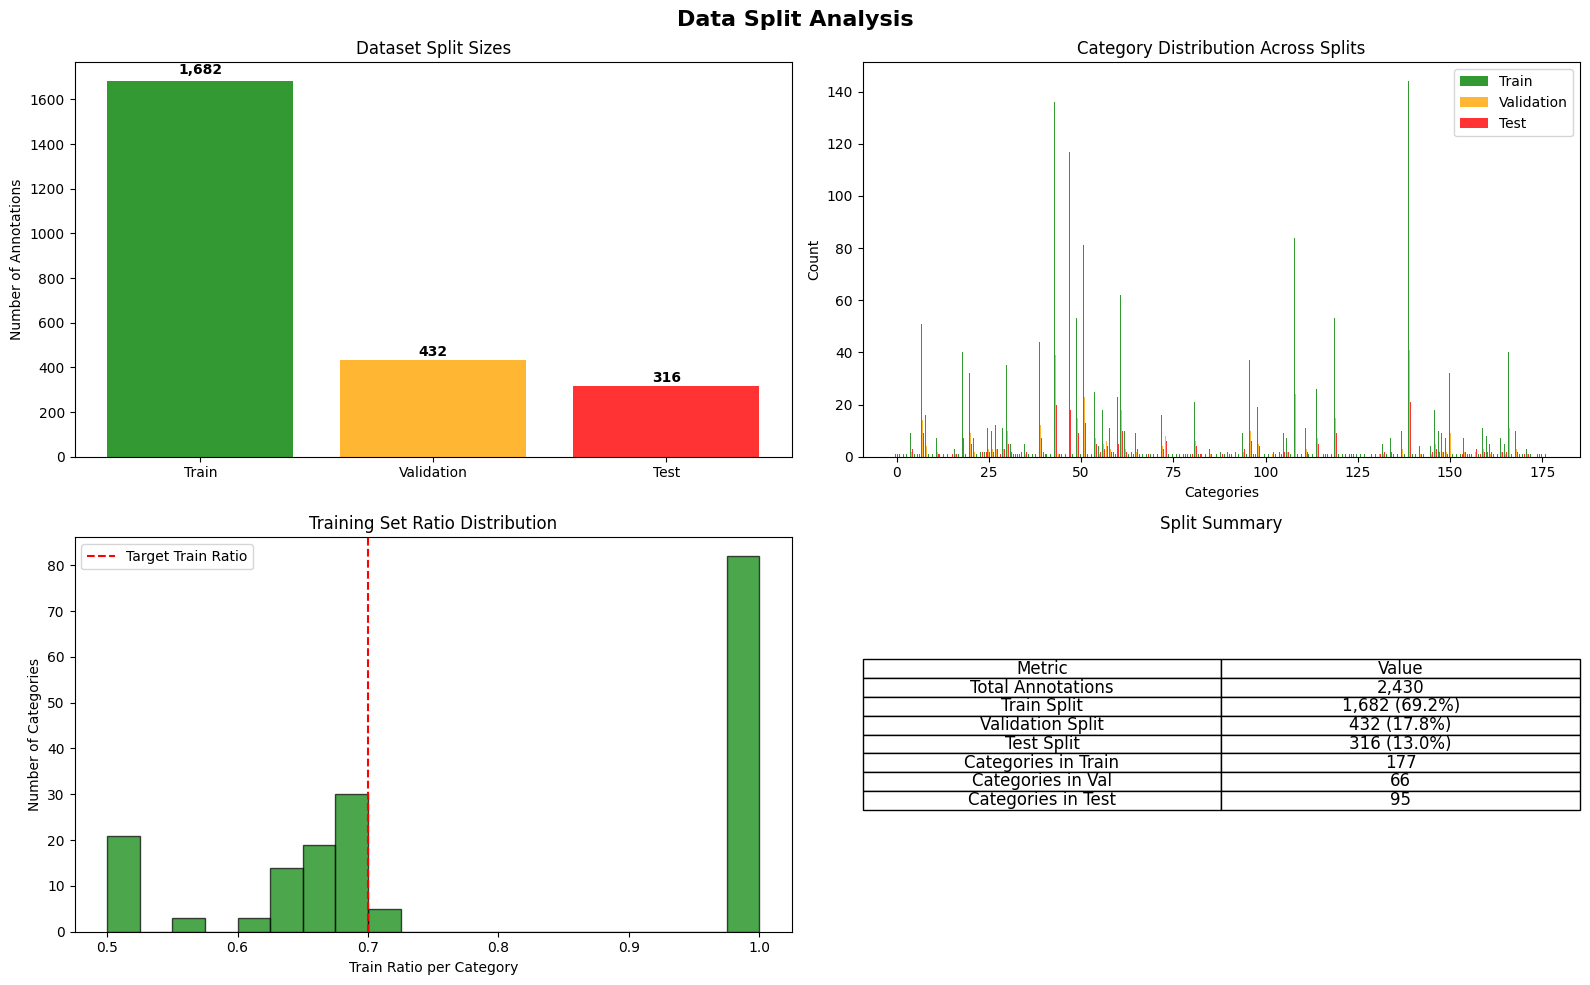


🔄 Category Overlap Analysis:
Categories in train set: 177
Categories in val set: 66
Categories in test set: 95
Categories in all three sets: 66
Categories only in train: 82
Categories only in val: 0
Categories only in test: 0


In [14]:
# Analyze data split quality
split_analysis_fig = visualizer.plot_data_split_analysis(
    train_data, val_data, test_data,
    save_path=f"{DATA_DIR}/analysis_plots/data_split_analysis.png"
)
plt.show()

# Check category overlap
train_cats = set(ann['category_id'] for ann in train_data['annotations'])
val_cats = set(ann['category_id'] for ann in val_data['annotations'])
test_cats = set(ann['category_id'] for ann in test_data['annotations'])

print(f"\n🔄 Category Overlap Analysis:")
print(f"Categories in train set: {len(train_cats)}")
print(f"Categories in val set: {len(val_cats)}")
print(f"Categories in test set: {len(test_cats)}")
print(f"Categories in all three sets: {len(train_cats & val_cats & test_cats)}")
print(f"Categories only in train: {len(train_cats - val_cats - test_cats)}")
print(f"Categories only in val: {len(val_cats - train_cats - test_cats)}")
print(f"Categories only in test: {len(test_cats - train_cats - val_cats)}")

In [15]:
# Save split data
print("Saving split datasets...")
os.makedirs(f"{DATA_DIR}/annotations", exist_ok=True)

dataset_utils.save_split_data(train_data, val_data, test_data,
                             output_dir=f"{DATA_DIR}/annotations")

print("✅ Split datasets saved successfully!")
print(f"Files saved:")
print(f"  - {DATA_DIR}/annotations/train_annotations.json")
print(f"  - {DATA_DIR}/annotations/val_annotations.json")
print(f"  - {DATA_DIR}/annotations/test_annotations.json")

Saving split datasets...
✅ Split datasets saved successfully!
Files saved:
  - /content/drive/My Drive/PapyrusNU_Detectron/data/annotations/train_annotations.json
  - /content/drive/My Drive/PapyrusNU_Detectron/data/annotations/val_annotations.json
  - /content/drive/My Drive/PapyrusNU_Detectron/data/annotations/test_annotations.json


## Detectron2 Dataset Preparation

In [16]:
# Convert to Detectron2 format
from dataset_utils import create_detectron2_dataset_dict
from detectron2.data import DatasetCatalog, MetadataCatalog

# Create dataset dictionaries for Detectron2
print("Converting to Detectron2 format...")

train_dataset_dicts = create_detectron2_dataset_dict(train_data, f"{DATA_DIR}/images")
val_dataset_dicts = create_detectron2_dataset_dict(val_data, f"{DATA_DIR}/images")
test_dataset_dicts = create_detectron2_dataset_dict(test_data, f"{DATA_DIR}/images")

print(f"Detectron2 datasets created:")
print(f"  Train: {len(train_dataset_dicts)} images")
print(f"  Val: {len(val_dataset_dicts)} images")
print(f"  Test: {len(test_dataset_dicts)} images")

# Register datasets with Detectron2
def get_hieroglyph_dicts(dataset_dicts):
    return dataset_dicts

# Clear existing registrations if any
for d in ["hieroglyphs_train", "hieroglyphs_val", "hieroglyphs_test"]:
    if d in DatasetCatalog:
        DatasetCatalog.remove(d)

# Register datasets
DatasetCatalog.register("hieroglyphs_train", lambda: train_dataset_dicts)
DatasetCatalog.register("hieroglyphs_val", lambda: val_dataset_dicts)
DatasetCatalog.register("hieroglyphs_test", lambda: test_dataset_dicts)

# Set metadata
category_names = [dataset_utils.categories[cat_id]['name'] for cat_id in sorted(dataset_utils.categories.keys())]

MetadataCatalog.get("hieroglyphs_train").set(thing_classes=category_names)
MetadataCatalog.get("hieroglyphs_val").set(thing_classes=category_names)
MetadataCatalog.get("hieroglyphs_test").set(thing_classes=category_names)

print("\n✅ Datasets registered with Detectron2!")
print(f"Number of categories: {len(category_names)}")
print(f"Sample categories: {category_names[:10]}...")

Converting to Detectron2 format...
Detectron2 datasets created:
  Train: 1 images
  Val: 1 images
  Test: 1 images

✅ Datasets registered with Detectron2!
Number of categories: 628
Sample categories: ['A1', 'A121C', 'A13', 'A131A', 'A13A', 'A14', 'A15', 'A16', 'A169', 'A17']...


## Sample Data Verification

In [17]:
# Verify a sample from each dataset
from detectron2.utils.visualizer import Visualizer
import random

# Load image and show sample annotations
def visualize_detectron2_sample(dataset_dicts, dataset_name, num_samples=2):
    metadata = MetadataCatalog.get(dataset_name)

    for i, d in enumerate(random.sample(dataset_dicts, min(num_samples, len(dataset_dicts)))):
        img = cv2.imread(d["file_name"])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        visualizer = Visualizer(img, metadata=metadata, scale=0.5)
        out = visualizer.draw_dataset_dict(d)

        plt.figure(figsize=(20, 12))
        plt.imshow(out.get_image())
        plt.title(f"{dataset_name} - Sample {i+1} (Image ID: {d['image_id']})")
        plt.axis('off')
        plt.show()

        print(f"Image: {d['file_name']}")
        print(f"Annotations: {len(d['annotations'])}")
        print(f"Image size: {d['height']}x{d['width']}")
        print("-" * 50)

print("🔍 Visualizing training samples...")
visualize_detectron2_sample(train_dataset_dicts, "hieroglyphs_train", num_samples=1)

print("\n🔍 Visualizing validation samples...")
visualize_detectron2_sample(val_dataset_dicts, "hieroglyphs_val", num_samples=1)

Output hidden; open in https://colab.research.google.com to view.

## Summary and Next Steps

In [18]:
# Create summary report
summary_report = {
    "dataset_info": {
        "total_images": len(dataset_utils.images),
        "total_annotations": len(dataset_utils.annotations),
        "total_categories": len(dataset_utils.categories),
        "unique_gardiner_codes": stats['unique_gardiner_codes'],
        "unique_unicode_codes": stats['unique_unicode_codes']
    },
    "data_split": {
        "train_annotations": len(train_data['annotations']),
        "val_annotations": len(val_data['annotations']),
        "test_annotations": len(test_data['annotations']),
        "train_categories": len(train_cats),
        "val_categories": len(val_cats),
        "test_categories": len(test_cats)
    },
    "class_balance": {
        "frequent_classes": len(class_balance['frequent_classes']),
        "common_classes": len(class_balance['common_classes']),
        "rare_classes": len(class_balance['rare_classes'])
    },
    "validation_issues": {k: len(v) for k, v in issues.items()},
    "files_created": [
        "train_annotations.json",
        "val_annotations.json",
        "test_annotations.json",
        "gardiner_unicode_mapping.json",
        "dataset_overview.png",
        "class_distribution.png",
        "sample_annotations.png",
        "data_split_analysis.png"
    ]
}

# Save summary report
summary_path = f"{DATA_DIR}/data_preparation_summary.json"
with open(summary_path, 'w') as f:
    json.dump(summary_report, f, indent=2)

print("📋 DATA PREPARATION SUMMARY")
print("=" * 50)
print(f"✅ Dataset loaded and validated")
print(f"✅ {len(dataset_utils.annotations):,} annotations across {len(dataset_utils.categories)} categories")
print(f"✅ Data split into train ({len(train_data['annotations']):,}), val ({len(val_data['annotations']):,}), test ({len(test_data['annotations']):,})")
print(f"✅ Datasets registered with Detectron2")
print(f"✅ Analysis plots and mappings created")
print(f"✅ Summary report saved to {summary_path}")

print("\n🚀 NEXT STEPS:")
print("1. Run notebook 02_data_analysis.ipynb for deeper analysis")
print("2. Run notebook 03_model_training.ipynb to train the model")
print("3. Run notebook 04_model_evaluation.ipynb to evaluate results")

print("\n⚠️  IMPORTANT NOTES:")
if class_balance['rare_classes']:
    print(f"- {len(class_balance['rare_classes'])} classes have very few examples (<1% of data)")
    print("  Consider data augmentation or class weighting during training")
if any(len(issues[k]) > 0 for k in issues):
    print("- Some validation issues were found. Review them before training")
print("- Single image dataset: Consider spatial augmentation during training")
print("- High number of categories: Expect longer training times")

📋 DATA PREPARATION SUMMARY
✅ Dataset loaded and validated
✅ 2,430 annotations across 628 categories
✅ Data split into train (1,682), val (432), test (316)
✅ Datasets registered with Detectron2
✅ Analysis plots and mappings created
✅ Summary report saved to /content/drive/My Drive/PapyrusNU_Detectron/data/data_preparation_summary.json

🚀 NEXT STEPS:
1. Run notebook 02_data_analysis.ipynb for deeper analysis
2. Run notebook 03_model_training.ipynb to train the model
3. Run notebook 04_model_evaluation.ipynb to evaluate results

⚠️  IMPORTANT NOTES:
- 152 classes have very few examples (<1% of data)
  Consider data augmentation or class weighting during training
- Single image dataset: Consider spatial augmentation during training
- High number of categories: Expect longer training times
